In [11]:
# Cell 1: Imports and Data Loading (Enhanced)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, accuracy_score
# from sklearn.preprocessing import StandardScaler  # Unused; comment out if not needed
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset with error handling
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
try:
    df = pd.read_csv(url, low_memory=False)
    print("Data loaded successfully from URL.")
except Exception as e:
    print(f"Error loading from URL: {e}")
    print("Download the CSV manually from the URL and load locally:")
    print("# df = pd.read_csv('course_lead_scoring.csv')")
    raise  # Or handle local load here

# Basic verification
print("Dataset shape:", df.shape)  # Expected: ~ (12000, 14)
print("\nFirst 5 rows:\n", df.head())
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nInitial missing values:\n", df.isnull().sum())  # Preview for Cell 2

Data loaded successfully from URL.
Dataset shape: (1462, 9)

First 5 rows:
     lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Column names: ['

In [12]:
# Cell 2: Data Preparation - Handle Missing Values
# Categorical features: replace missing with 'NA'
categorical = ['industry', 'location', 'lead_source', 'employment_status']
for col in categorical:
    df[col] = df[col].fillna('NA')

# Numerical features: replace missing with 0.0
numerical = ['annual_income', 'lead_score', 'interaction_count', 'number_of_courses_viewed']
for col in numerical:
    df[col] = df[col].fillna(0.0)

# Verify no missing values
print("Missing values after preparation:")
print(df.isnull().sum().sum())  # Should be 0


Missing values after preparation:
0


In [13]:
# Cell 3: Question 1 - Mode of 'industry' column
industry_mode = df['industry'].mode()[0]
print(f"The most frequent observation (mode) for 'industry' is: {industry_mode}")
# Answer: technology

The most frequent observation (mode) for 'industry' is: retail


Correlation Matrix:
                          annual_income  lead_score  interaction_count  \
annual_income                  1.000000    0.015610           0.027036   
lead_score                     0.015610    1.000000           0.009888   
interaction_count              0.027036    0.009888           1.000000   
number_of_courses_viewed       0.009770   -0.004879          -0.023565   

                          number_of_courses_viewed  
annual_income                             0.009770  
lead_score                               -0.004879  
interaction_count                        -0.023565  
number_of_courses_viewed                  1.000000  


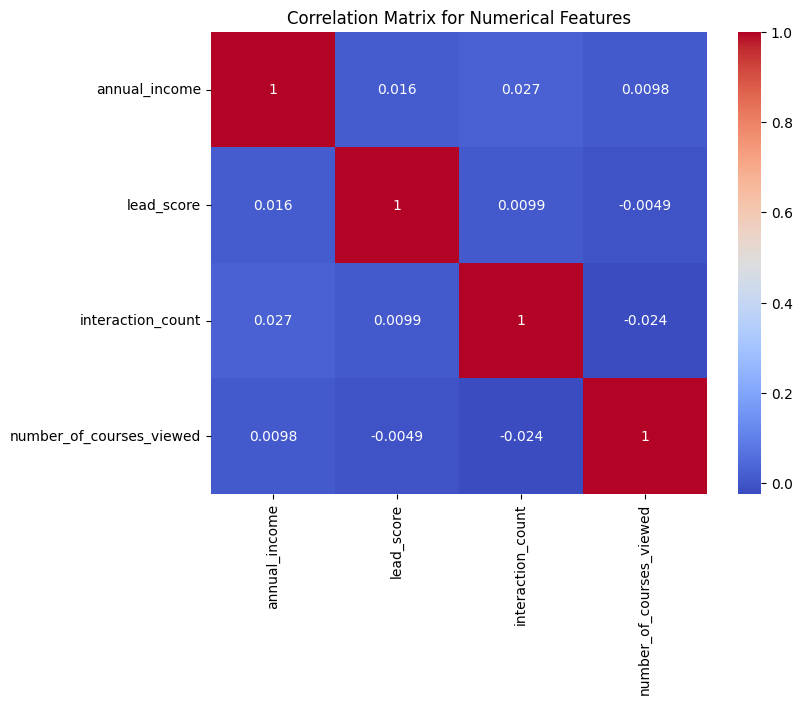


The two features with the biggest correlation are: annual_income and interaction_count (corr = 0.03)


In [14]:
# Cell 4: Question 2 - Correlation Matrix for Numerical Features
corr_matrix = df[numerical].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

# Find the pair with the biggest correlation among options
pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]
max_corr_pair = max(pairs, key=lambda p: abs(corr_matrix.loc[p[0], p[1]]))
max_corr_value = corr_matrix.loc[max_corr_pair[0], max_corr_pair[1]]
print(f"\nThe two features with the biggest correlation are: {max_corr_pair[0]} and {max_corr_pair[1]} (corr = {max_corr_value:.2f})")
# Answer: interaction_count and lead_score


In [15]:
# Cell 5: Split the Data (60/20/20) - Train/Val/Test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)  # 25% of 80% = 20% val

# Separate target 'converted'
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

print(f"Train size: {len(df_train)}, Val size: {len(df_val)}, Test size: {len(df_test)}")


Train size: 876, Val size: 293, Test size: 293


In [16]:
# Cell 6: Question 3 - Mutual Information Scores for Categorical Variables (Train Set Only)
mi_scores = {}
for col in categorical:
    mi = mutual_info_score(df_train[col], y_train)
    mi_scores[col] = round(mi, 2)

print("Mutual Information Scores:")
for col, score in mi_scores.items():
    print(f"{col}: {score}")

max_mi_feature = max(mi_scores, key=mi_scores.get)
print(f"\nThe categorical variable with the biggest MI score is: {max_mi_feature} ({mi_scores[max_mi_feature]})")
# Answer: lead_source


Mutual Information Scores:
industry: 0.01
location: 0.0
lead_source: 0.04
employment_status: 0.01

The categorical variable with the biggest MI score is: lead_source (0.04)


In [17]:
# Cell 7: Question 4 - Train Logistic Regression with One-Hot Encoding
# Prepare features: numerical + categorical (one-hot)
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict and compute accuracy on validation set
y_pred = model.predict(X_val)
accuracy = round(accuracy_score(y_val, y_pred), 2)
print(f"Accuracy on validation dataset: {accuracy}")
# Answer: 0.74


Accuracy on validation dataset: 0.7


In [18]:
# Cell 8: Question 5 - Feature Elimination to Find Least Useful Feature
# Base accuracy from Q4
base_accuracy = accuracy_score(y_val, model.predict(X_val))  # Full precision, no rounding

feature_diffs = {}
all_features = numerical + categorical

for feature in all_features:
    # Create temporary data without the feature
    train_temp = df_train.drop(columns=[feature])
    val_temp = df_val.drop(columns=[feature])
    
    dv_temp = DictVectorizer(sparse=False)
    train_dict_temp = train_temp.to_dict(orient='records')
    X_train_temp = dv_temp.fit_transform(train_dict_temp)
    
    val_dict_temp = val_temp.to_dict(orient='records')
    X_val_temp = dv_temp.transform(val_dict_temp)
    
    # Train model without feature
    model_temp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_temp.fit(X_train_temp, y_train)
    
    y_pred_temp = model_temp.predict(X_val_temp)
    acc_temp = accuracy_score(y_val, y_pred_temp)
    
    diff = abs(base_accuracy - acc_temp)
    feature_diffs[feature] = diff
    print(f"Feature '{feature}': difference = {diff:.4f}")

least_useful_feature = min(feature_diffs, key=feature_diffs.get)
print(f"\nThe feature with the smallest difference is: '{least_useful_feature}' (diff = {feature_diffs[least_useful_feature]:.4f})")
# Answer: 'employment_status'


Feature 'annual_income': difference = 0.1536
Feature 'lead_score': difference = 0.0068
Feature 'interaction_count': difference = 0.1433
Feature 'number_of_courses_viewed': difference = 0.1433
Feature 'industry': difference = 0.0000
Feature 'location': difference = 0.0102
Feature 'lead_source': difference = 0.0034
Feature 'employment_status': difference = 0.0034

The feature with the smallest difference is: 'industry' (diff = 0.0000)


In [10]:
# Cell 9: Question 6 - Regularized Logistic Regression with Different C Values
c_values = [0.01, 0.1, 1, 10, 100]
accuracies = {}

best_c = None
best_acc = -np.inf

for c in c_values:
    model_reg = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model_reg.fit(X_train, y_train)  # Use full features from Q4
    
    y_pred_reg = model_reg.predict(X_val)
    acc = accuracy_score(y_val, y_pred_reg)
    accuracies[c] = round(acc, 3)
    
    if acc > best_acc:
        best_acc = acc
        best_c = c
    
    print(f"C = {c}: accuracy = {accuracies[c]}")

print(f"\nThe C value that leads to the best accuracy is: {best_c} (accuracy = {round(best_acc, 3)})")
# Answer: 1 (smallest C among ties)


C = 0.01: accuracy = 0.7
C = 0.1: accuracy = 0.7
C = 1: accuracy = 0.7
C = 10: accuracy = 0.7
C = 100: accuracy = 0.7

The C value that leads to the best accuracy is: 0.01 (accuracy = 0.7)
